# Experiment: MSFT 1-Minute GRU Forecast (Anti-Collapse v2)

This notebook implements all requested fixes:
1. Exclude windows touching imputed bars (no synthetic-bar contamination)
2. Multi-step training objective with scheduled sampling (h=15)
3. Relaxed clipping bounds for recursive rollout
4. Larger model + lower regularization
5. Auxiliary direction loss (BCE)
6. Directional diagnostics with epsilon threshold

It also adds volume/order-flow features to the model input state.


In [1]:
# Optional dependency bootstrap
import importlib.util
import subprocess
import sys

required = {
    'alpaca': 'alpaca-py',
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
}

missing = [pkg for module_name, pkg in required.items() if importlib.util.find_spec(module_name) is None]
if missing:
    print('Installing missing packages:', missing)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *missing])
else:
    print('All required third-party packages are already installed.')


All required third-party packages are already installed.


In [2]:
# Setup
from __future__ import annotations

import copy
import os
import random
import time
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from alpaca.data.enums import DataFeed
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import DataLoader, Dataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {DEVICE}')
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
    print('CUDA:', torch.version.cuda)


Using device: cuda
GPU: NVIDIA GeForce RTX 3070
CUDA: 12.1


## Config

- Feed default: `iex` (free-plan friendly)
- Sessionization: weekday RTH 09:30-15:59 ET
- Forecast mode: recursive 15-step
- Target: transformed candle-price features + volume/order-flow features


In [3]:
# Configuration
SYMBOL = 'MSFT'
LOOKBACK_DAYS = 60

OHLC_COLS = ['Open', 'High', 'Low', 'Close']
RAW_COLS = OHLC_COLS + ['Volume', 'TradeCount', 'VWAP']

FEATURE_COLS = [
    'rOpen',
    'rHigh',
    'rLow',
    'rClose',
    'logVolChange',
    'logTradeCountChange',
    'vwapDelta',
    'rangeFrac',
    'orderFlowProxy',
    'tickPressure',
]

WINDOW = 500
HORIZON = 15
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

# Model/training (item 4)
BATCH_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 3
DROPOUT = 0.0
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
MAX_EPOCHS = 40
EARLY_STOPPING_PATIENCE = 8

# Losses (item 5)
LOSS_WEIGHTS = np.array([1.0, 1.0, 1.0, 2.0, 0.4, 0.4, 0.3, 0.5, 0.6, 0.6], dtype=np.float32)
HUBER_DELTA = 1.0
DIR_LOSS_WEIGHT = 0.25

# Scheduled sampling (item 2)
TF_START = 1.0
TF_END = 0.2

# Clipping (item 3): wider bounds than previous run
CLIP_TARGET_QUANTILES = (0.001, 0.999)

# Direction diagnostics (item 6)
DIRECTION_EPS = 0.02

# Alpaca / session
ALPACA_FEED = os.getenv('ALPACA_FEED', 'iex').strip().lower()
USE_RTH_ONLY = True
SESSION_TZ = 'America/New_York'
RTH_START = '09:30'
RTH_END = '16:00'
REQUEST_CHUNK_DAYS = 5
MAX_REQUESTS_PER_MINUTE = 120
MAX_RETRIES = 5

print({
    'symbol': SYMBOL,
    'lookback_days': LOOKBACK_DAYS,
    'features': len(FEATURE_COLS),
    'window': WINDOW,
    'horizon': HORIZON,
    'alpaca_feed': ALPACA_FEED,
    'hidden_size': HIDDEN_SIZE,
    'layers': NUM_LAYERS,
    'dropout': DROPOUT,
    'tf_schedule': (TF_START, TF_END),
    'clip_quantiles': CLIP_TARGET_QUANTILES,
    'direction_eps': DIRECTION_EPS,
    'device': str(DEVICE),
})


{'symbol': 'MSFT', 'lookback_days': 60, 'features': 10, 'window': 500, 'horizon': 15, 'alpaca_feed': 'iex', 'hidden_size': 256, 'layers': 3, 'dropout': 0.0, 'tf_schedule': (1.0, 0.2), 'clip_quantiles': (0.001, 0.999), 'direction_eps': 0.02, 'device': 'cuda'}


In [4]:
# Data pull + sessionization with imputation flags
class RequestPacer:
    def __init__(self, max_calls_per_minute: int):
        if max_calls_per_minute <= 0:
            raise ValueError('max_calls_per_minute must be > 0')
        self.min_interval = 60.0 / float(max_calls_per_minute)
        self.last_call_ts = 0.0

    def wait(self) -> None:
        now = time.monotonic()
        elapsed = now - self.last_call_ts
        if elapsed < self.min_interval:
            time.sleep(self.min_interval - elapsed)
        self.last_call_ts = time.monotonic()


def _require_alpaca_credentials() -> tuple[str, str]:
    api_key = os.getenv('ALPACA_API_KEY')
    secret_key = os.getenv('ALPACA_SECRET_KEY')
    if not api_key or not secret_key:
        raise RuntimeError('Missing ALPACA_API_KEY / ALPACA_SECRET_KEY environment variables.')
    return api_key, secret_key


def _resolve_feed(feed_name: str) -> DataFeed:
    mapping = {'iex': DataFeed.IEX, 'sip': DataFeed.SIP, 'delayed_sip': DataFeed.DELAYED_SIP}
    k = feed_name.strip().lower()
    if k not in mapping:
        raise ValueError(f'Unsupported ALPACA_FEED={feed_name!r}. Use one of: {list(mapping)}')
    return mapping[k]


def fetch_bars_alpaca(symbol: str, lookback_days: int) -> tuple[pd.DataFrame, int]:
    api_key, secret_key = _require_alpaca_credentials()
    client = StockHistoricalDataClient(api_key=api_key, secret_key=secret_key)

    feed = _resolve_feed(ALPACA_FEED)
    pacer = RequestPacer(MAX_REQUESTS_PER_MINUTE)

    end_ts = datetime.now(timezone.utc).replace(second=0, microsecond=0)
    if ALPACA_FEED in {'sip', 'delayed_sip'}:
        end_ts = end_ts - timedelta(minutes=20)
    start_ts = end_ts - timedelta(days=lookback_days)

    frames = []
    cursor = start_ts
    calls = 0

    while cursor < end_ts:
        chunk_end = min(cursor + timedelta(days=REQUEST_CHUNK_DAYS), end_ts)
        chunk = None

        for attempt in range(1, MAX_RETRIES + 1):
            pacer.wait()
            calls += 1
            try:
                req = StockBarsRequest(
                    symbol_or_symbols=[symbol],
                    timeframe=TimeFrame.Minute,
                    start=cursor,
                    end=chunk_end,
                    feed=feed,
                    limit=10_000,
                )
                chunk = client.get_stock_bars(req).df
                break
            except Exception as exc:
                msg = str(exc).lower()
                if ('429' in msg or 'rate limit' in msg) and attempt < MAX_RETRIES:
                    backoff = min(2 ** attempt, 30)
                    print(f'Rate-limited; backoff {backoff}s (attempt {attempt}/{MAX_RETRIES}).')
                    time.sleep(backoff)
                    continue
                if ('subscription' in msg or 'forbidden' in msg) and ALPACA_FEED != 'iex':
                    raise RuntimeError('Requested feed unavailable. Use ALPACA_FEED=iex for free-plan compatibility.') from exc
                raise

        if chunk is not None and not chunk.empty:
            d = chunk.reset_index().rename(
                columns={
                    'timestamp': 'Datetime',
                    'open': 'Open',
                    'high': 'High',
                    'low': 'Low',
                    'close': 'Close',
                    'volume': 'Volume',
                    'trade_count': 'TradeCount',
                    'vwap': 'VWAP',
                }
            )

            if 'VWAP' not in d.columns:
                d['VWAP'] = d.get('Close')
            if 'TradeCount' not in d.columns:
                d['TradeCount'] = 0
            if 'Volume' not in d.columns:
                d['Volume'] = 0

            keep = ['Datetime'] + RAW_COLS
            missing = [c for c in keep if c not in d.columns]
            if missing:
                raise RuntimeError(f'Alpaca response missing columns: {missing}')

            d['Datetime'] = pd.to_datetime(d['Datetime'], utc=True)
            d = d[keep].dropna(subset=OHLC_COLS).set_index('Datetime').sort_index()
            frames.append(d)

        cursor = chunk_end

    if not frames:
        raise RuntimeError('No bars returned from Alpaca.')

    df = pd.concat(frames, axis=0).sort_index()
    df = df[~df.index.duplicated(keep='last')]
    return df.astype(np.float32), calls


def sessionize(df_utc: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    if df_utc.empty:
        raise RuntimeError('Input bars are empty.')

    local = df_utc.copy()
    idx = pd.DatetimeIndex(local.index)
    if idx.tz is None:
        idx = idx.tz_localize('UTC')
    idx = idx.tz_convert(SESSION_TZ)
    local.index = idx

    local = local[local.index.dayofweek < 5]
    if USE_RTH_ONLY:
        local = local.between_time(RTH_START, RTH_END, inclusive='left')

    if local.empty:
        raise RuntimeError('No rows after weekday/RTH filtering.')

    session_dates = pd.Index(local.index.date).unique().tolist()
    raw_counts = {d: int((local.index.date == d).sum()) for d in session_dates}

    latest_date = max(raw_counts.keys())
    drop_latest = raw_counts[latest_date] < 390

    pieces = []
    fill_counts = []

    for d in session_dates:
        if drop_latest and d == latest_date:
            continue

        day = local[local.index.date == d][RAW_COLS].copy()
        day_start = pd.Timestamp(f'{d} {RTH_START}', tz=SESSION_TZ)
        exp_idx = pd.date_range(day_start, periods=390, freq='1min')

        day = day.reindex(exp_idx)
        imputed = day['Open'].isna() | day['High'].isna() | day['Low'].isna() | day['Close'].isna()
        fill_counts.append(int(imputed.sum()))

        # Fill OHLC/VWAP for continuity, mark imputed so they can be excluded from windows.
        day[OHLC_COLS + ['VWAP']] = day[OHLC_COLS + ['VWAP']].ffill().bfill()
        day['Volume'] = day['Volume'].fillna(0.0)
        day['TradeCount'] = day['TradeCount'].fillna(0.0)
        day['is_imputed'] = imputed.astype(np.int8)

        if day[RAW_COLS].isna().any().any():
            raise RuntimeError(f'Session {d} still has NaNs after fill.')

        pieces.append(day)

    if not pieces:
        raise RuntimeError('No complete sessions after filtering.')

    out = pd.concat(pieces, axis=0).sort_index()

    sizes = out.groupby(out.index.date).size()
    assert bool((sizes == 390).all()), 'Each kept session must have 390 bars.'

    out.index = out.index.tz_localize(None)

    meta = {
        'raw_sessions': len(session_dates),
        'kept_sessions': int(len(sizes)),
        'dropped_latest_session': bool(drop_latest),
        'latest_session_raw_count': int(raw_counts[latest_date]),
        'avg_filled_bars_per_session': float(np.mean(fill_counts)),
        'max_filled_bars_in_session': int(np.max(fill_counts)),
    }
    return out.astype(np.float32), meta


raw_df_utc, api_calls = fetch_bars_alpaca(SYMBOL, LOOKBACK_DAYS)
price_df, session_meta = sessionize(raw_df_utc)

print(f'Raw rows from Alpaca: {len(raw_df_utc):,}')
print(f'Sessionized rows: {len(price_df):,}')
print(f'Alpaca API calls: {api_calls} (<= {MAX_REQUESTS_PER_MINUTE}/min target)')
print('Session meta:', session_meta)

if len(price_df) < WINDOW + HORIZON + 1000:
    raise RuntimeError('Not enough rows for robust multi-step training.')

display(price_df.head(3))
display(price_df.tail(3))


Raw rows from Alpaca: 15,082
Sessionized rows: 15,210
Alpaca API calls: 12 (<= 120/min target)
Session meta: {'raw_sessions': 39, 'kept_sessions': 39, 'dropped_latest_session': False, 'latest_session_raw_count': 390, 'avg_filled_bars_per_session': 8.58974358974359, 'max_filled_bars_in_session': 196}


,Open,High,Low,Close,Volume,TradeCount,VWAP,is_imputed
2025-12-12 09:30:00,479.980011,480.700012,478.864990,480.644989,2928.0,90.0,479.834015,0.0
2025-12-12 09:31:00,480.420013,482.160004,480.165009,481.970001,3306.0,83.0,481.402679,0.0
2025-12-12 09:32:00,481.709991,481.829987,481.339996,481.654999,1777.0,36.0,481.650818,0.0


,Open,High,Low,Close,Volume,TradeCount,VWAP,is_imputed
2026-02-09 15:57:00,413.480011,414.130005,413.399994,414.049988,20946.0,328.0,413.838928,0.0
2026-02-09 15:58:00,414.029999,414.179993,414.029999,414.109985,14422.0,345.0,414.109253,0.0
2026-02-09 15:59:00,414.065002,414.149994,413.559998,413.690002,40008.0,467.0,414.002441,0.0


In [5]:
# Feature engineering (includes volume/order-flow) + transform checks
def enforce_candle_validity(ohlc: np.ndarray) -> np.ndarray:
    out = np.asarray(ohlc, dtype=np.float32).copy()
    o, h, l, c = out[:, 0], out[:, 1], out[:, 2], out[:, 3]
    out[:, 1] = np.maximum.reduce([h, o, c])
    out[:, 2] = np.minimum.reduce([l, o, c])
    return out


def returns_to_prices_seq(return_ohlc: np.ndarray, last_close: float) -> np.ndarray:
    seq = []
    prev_close = float(last_close)
    for rO, rH, rL, rC in np.asarray(return_ohlc, dtype=np.float32):
        o = prev_close * np.exp(float(rO))
        h = prev_close * np.exp(float(rH))
        l = prev_close * np.exp(float(rL))
        c = prev_close * np.exp(float(rC))
        cand = enforce_candle_validity(np.array([[o, h, l, c]], dtype=np.float32))[0]
        seq.append(cand)
        prev_close = float(cand[3])
    return np.asarray(seq, dtype=np.float32)


def one_step_returns_to_prices_batch(return_ohlc: np.ndarray, prev_close: np.ndarray) -> np.ndarray:
    r = np.asarray(return_ohlc, dtype=np.float32)
    p = np.asarray(prev_close, dtype=np.float32)

    out = np.stack([
        p * np.exp(r[:, 0]),
        p * np.exp(r[:, 1]),
        p * np.exp(r[:, 2]),
        p * np.exp(r[:, 3]),
    ], axis=1).astype(np.float32)
    return enforce_candle_validity(out)


def build_feature_frame(df: pd.DataFrame) -> pd.DataFrame:
    eps = 1e-9

    prev_close = df['Close'].shift(1)
    prev_vol = df['Volume'].shift(1)
    prev_tc = df['TradeCount'].shift(1)

    valid = prev_close.notna() & prev_vol.notna() & prev_tc.notna()

    c = df.loc[valid]
    base_close = prev_close.loc[valid]

    out = pd.DataFrame(index=c.index, dtype=np.float32)

    # Candle-price returns (core target components)
    out['rOpen'] = np.log(c['Open'] / (base_close + eps))
    out['rHigh'] = np.log(c['High'] / (base_close + eps))
    out['rLow'] = np.log(c['Low'] / (base_close + eps))
    out['rClose'] = np.log(c['Close'] / (base_close + eps))

    # Volume/order-flow style features
    out['logVolChange'] = np.log((c['Volume'] + 1.0) / (prev_vol.loc[valid] + 1.0))
    out['logTradeCountChange'] = np.log((c['TradeCount'] + 1.0) / (prev_tc.loc[valid] + 1.0))
    out['vwapDelta'] = np.log((c['VWAP'] + eps) / (c['Close'] + eps))
    out['rangeFrac'] = (c['High'] - c['Low']) / (base_close + eps)

    signed_body = (c['Close'] - c['Open']) / ((c['High'] - c['Low']) + eps)
    out['orderFlowProxy'] = signed_body * np.log1p(c['Volume'])
    out['tickPressure'] = np.sign(c['Close'] - c['Open']) * np.log1p(c['TradeCount'])

    # Mark feature rows influenced by imputed bars in either t-1 or t (item 1).
    imp = df['is_imputed'].astype(bool).to_numpy()
    imp_feat = imp[1:] | imp[:-1]
    out['invalid_feature_row'] = imp_feat.astype(np.int8)

    # Prev close aligned for reconstructing price from predicted returns.
    out['prev_close'] = base_close.astype(np.float32)

    return out.astype(np.float32)


feat_df = build_feature_frame(price_df)
print('Feature rows:', len(feat_df))
print('Invalid feature rows (imputation-affected):', int(feat_df['invalid_feature_row'].sum()))

# Round-trip check for OHLC return transform component
round_n = min(2000, len(price_df))
sub = price_df.iloc[:round_n].copy()
sub_feat = build_feature_frame(sub)
ret = sub_feat[['rOpen', 'rHigh', 'rLow', 'rClose']].to_numpy(np.float32)
recon = returns_to_prices_seq(ret, float(sub['Close'].iloc[0]))
actual = sub[OHLC_COLS].iloc[1:].to_numpy(np.float32)

rt_max = float(np.max(np.abs(recon - actual)))
rt_mean = float(np.mean(np.abs(recon - actual)))
print({'roundtrip_max_abs_error': rt_max, 'roundtrip_mean_abs_error': rt_mean})
assert rt_max < 2e-3, 'Round-trip transform error too large.'

display(feat_df[FEATURE_COLS + ['invalid_feature_row', 'prev_close']].head(3))


Feature rows: 15209
Invalid feature rows (imputation-affected): 463
{'roundtrip_max_abs_error': 0.001068115234375, 'roundtrip_mean_abs_error': 0.0003963086928706616}


,rOpen,rHigh,rLow,rClose,logVolChange,logTradeCountChange,vwapDelta,rangeFrac,orderFlowProxy,tickPressure,invalid_feature_row,prev_close
2025-12-12 09:31:00,-0.000468,0.003147,-0.000999,0.002753,0.121380,-0.080043,-0.001178,0.004151,6.296149,4.430817,0.0,480.644989
2025-12-12 09:32:00,-0.000540,-0.000291,-0.001308,-0.000654,-0.620552,-0.819899,-0.000009,0.001017,-0.839861,-3.610918,0.0,481.970001
2025-12-12 09:33:00,-0.000301,0.000695,-0.000311,-0.000073,0.459473,0.637577,0.000070,0.001007,1.801256,4.248495,0.0,481.654999


In [6]:
# Windowing, splits, and dataset
def fit_standardizer(train_values: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    mean = train_values.mean(axis=0)
    std = train_values.std(axis=0)
    std = np.where(std < 1e-8, 1.0, std)
    return mean.astype(np.float32), std.astype(np.float32)


def apply_standardizer(values: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return ((values - mean) / std).astype(np.float32)


def undo_standardizer(values: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (values * std + mean).astype(np.float32)


def build_walkforward_slices(price_df_full: pd.DataFrame) -> list[tuple[str, int, int]]:
    n = len(price_df_full)
    span = int(round(n * 0.85))
    shift = max(1, n - span)

    cands = [('slice_1', 0, min(span, n)), ('slice_2', shift, min(shift + span, n))]

    out = []
    seen = set()
    for name, a, b in cands:
        key = (a, b)
        if key in seen:
            continue
        if b - a < WINDOW + HORIZON + 1500:
            continue
        out.append((name, a, b))
        seen.add(key)

    if not out:
        raise RuntimeError('Unable to create walk-forward slices with enough rows.')
    return out


def make_multistep_windows(
    values_scaled: np.ndarray,
    values_raw: np.ndarray,
    invalid_rows: np.ndarray,
    window: int,
    horizon: int,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int]:
    X = []
    y_scaled = []
    y_raw = []
    starts = []
    dropped_invalid = 0

    n = len(values_scaled)
    for i in range(window, n - horizon + 1):
        # Exclude any sample whose input or target touches imputation-affected rows (item 1).
        if invalid_rows[i - window : i + horizon].any():
            dropped_invalid += 1
            continue

        X.append(values_scaled[i - window : i])
        y_scaled.append(values_scaled[i : i + horizon])
        y_raw.append(values_raw[i : i + horizon])
        starts.append(i)

    return (
        np.asarray(X, dtype=np.float32),
        np.asarray(y_scaled, dtype=np.float32),
        np.asarray(y_raw, dtype=np.float32),
        np.asarray(starts, dtype=np.int64),
        dropped_invalid,
    )


class MultiStepDataset(Dataset):
    def __init__(self, X: np.ndarray, y_scaled: np.ndarray, y_raw: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y_scaled = torch.from_numpy(y_scaled).float()
        self.y_raw = torch.from_numpy(y_raw).float()

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y_scaled[idx], self.y_raw[idx]


slices = build_walkforward_slices(price_df)
print('Walk-forward slices:', slices)


Walk-forward slices: [('slice_1', 0, 12928), ('slice_2', 2282, 15210)]


In [7]:
# Model and optimization (multi-step + scheduled sampling + direction head)
class Seq2SeqGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float, horizon: int):
        super().__init__()
        self.horizon = horizon

        self.encoder = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        self.decoder_cell = nn.GRUCell(input_size, hidden_size)
        self.feature_head = nn.Linear(hidden_size, input_size)
        self.direction_head = nn.Linear(hidden_size, 1)

    def forward(
        self,
        x: torch.Tensor,
        y_teacher: torch.Tensor | None = None,
        teacher_forcing_ratio: float = 0.0,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        _, h = self.encoder(x)
        h_dec = h[-1]

        dec_input = x[:, -1, :]

        feats = []
        dirs = []

        for t in range(self.horizon):
            h_dec = self.decoder_cell(dec_input, h_dec)
            feat_pred = self.feature_head(h_dec)
            dir_logit = self.direction_head(h_dec).squeeze(-1)

            feats.append(feat_pred.unsqueeze(1))
            dirs.append(dir_logit.unsqueeze(1))

            if y_teacher is not None:
                if teacher_forcing_ratio >= 1.0:
                    dec_input = y_teacher[:, t, :]
                elif teacher_forcing_ratio <= 0.0:
                    dec_input = feat_pred
                else:
                    m = (torch.rand(x.size(0), device=x.device) < teacher_forcing_ratio).unsqueeze(1)
                    dec_input = torch.where(m, y_teacher[:, t, :], feat_pred)
            else:
                dec_input = feat_pred

        feat_seq = torch.cat(feats, dim=1)
        dir_seq = torch.cat(dirs, dim=1)
        return feat_seq, dir_seq


class WeightedHuberSeqLoss(nn.Module):
    def __init__(self, weights: np.ndarray, delta: float = 1.0):
        super().__init__()
        self.delta = float(delta)
        self.register_buffer('weights', torch.as_tensor(weights, dtype=torch.float32).view(1, 1, -1))

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        e = pred - target
        ae = torch.abs(e)
        huber = torch.where(ae <= self.delta, 0.5 * e * e, self.delta * (ae - 0.5 * self.delta))
        w = huber * self.weights
        return w.mean()


def tf_ratio_for_epoch(epoch: int, total_epochs: int, start: float, end: float) -> float:
    if total_epochs <= 1:
        return float(end)
    p = (epoch - 1) / float(total_epochs - 1)
    return float(start + (end - start) * p)


def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    reg_loss_fn: nn.Module,
    dir_loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer | None = None,
    tf_ratio: float = 0.0,
) -> dict:
    is_train = optimizer is not None
    model.train(is_train)

    total = 0.0
    reg_total = 0.0
    dir_total = 0.0
    n_items = 0

    for xb, yb_scaled, yb_raw in loader:
        xb = xb.to(DEVICE)
        yb_scaled = yb_scaled.to(DEVICE)
        yb_raw = yb_raw.to(DEVICE)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            pred_seq, dir_logits = model(
                xb,
                y_teacher=yb_scaled if is_train else None,
                teacher_forcing_ratio=tf_ratio if is_train else 0.0,
            )

            reg_loss = reg_loss_fn(pred_seq, yb_scaled)

            dir_target = (yb_raw[:, :, 3] > 0.0).float()
            dir_loss = dir_loss_fn(dir_logits, dir_target)

            loss = reg_loss + DIR_LOSS_WEIGHT * dir_loss

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = xb.size(0)
        total += loss.item() * bs
        reg_total += reg_loss.item() * bs
        dir_total += dir_loss.item() * bs
        n_items += bs

    return {
        'total': total / max(n_items, 1),
        'reg': reg_total / max(n_items, 1),
        'dir': dir_total / max(n_items, 1),
    }


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader) -> pd.DataFrame:
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-5
    )

    reg_loss_fn = WeightedHuberSeqLoss(LOSS_WEIGHTS, delta=HUBER_DELTA).to(DEVICE)
    dir_loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)

    best_val = float('inf')
    best_state = copy.deepcopy(model.state_dict())
    wait = 0
    rows = []

    for epoch in range(1, MAX_EPOCHS + 1):
        tf_ratio = tf_ratio_for_epoch(epoch, MAX_EPOCHS, TF_START, TF_END)

        tr = run_epoch(model, train_loader, reg_loss_fn, dir_loss_fn, optimizer=optimizer, tf_ratio=tf_ratio)
        va = run_epoch(model, val_loader, reg_loss_fn, dir_loss_fn, optimizer=None, tf_ratio=0.0)

        scheduler.step(va['total'])
        lr = optimizer.param_groups[0]['lr']

        rows.append({
            'epoch': epoch,
            'tf_ratio': tf_ratio,
            'lr': lr,
            'train_total': tr['total'],
            'val_total': va['total'],
            'train_reg': tr['reg'],
            'val_reg': va['reg'],
            'train_dir': tr['dir'],
            'val_dir': va['dir'],
        })

        print(
            f"Epoch {epoch:02d} | tf={tf_ratio:.3f} | "
            f"train={tr['total']:.5f} (reg={tr['reg']:.5f}, dir={tr['dir']:.5f}) | "
            f"val={va['total']:.5f} (reg={va['reg']:.5f}, dir={va['dir']:.5f}) | lr={lr:.6g}"
        )

        if va['total'] < best_val:
            best_val = va['total']
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= EARLY_STOPPING_PATIENCE:
                print(f'Early stopping at epoch {epoch}.')
                break

    model.load_state_dict(best_state)
    return pd.DataFrame(rows)


In [8]:
# Metrics, baselines, recursive rollout, and fold pipeline
def rmse(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.sqrt(np.mean((np.asarray(a) - np.asarray(b)) ** 2)))


def directional_accuracy_eps(actual_close: np.ndarray, pred_close: np.ndarray, prev_close: np.ndarray, eps: float) -> float:
    actual_move = np.asarray(actual_close) - np.asarray(prev_close)
    pred_move = np.asarray(pred_close) - np.asarray(prev_close)

    mask = np.abs(actual_move) > eps
    if not np.any(mask):
        return float('nan')

    a = np.sign(actual_move[mask])
    p = np.sign(pred_move[mask])
    return float(np.mean(a == p))


def evaluate_metrics(actual_ohlc: np.ndarray, pred_ohlc: np.ndarray, prev_close: np.ndarray, eps: float) -> dict:
    actual_ohlc = np.asarray(actual_ohlc, dtype=np.float32)
    pred_ohlc = np.asarray(pred_ohlc, dtype=np.float32)
    prev_close = np.asarray(prev_close, dtype=np.float32)

    ac = actual_ohlc[:, 3]
    pc = pred_ohlc[:, 3]

    return {
        'close_mae': float(np.mean(np.abs(ac - pc))),
        'close_rmse': rmse(ac, pc),
        'ohlc_mae': float(np.mean(np.abs(actual_ohlc - pred_ohlc))),
        'ohlc_rmse': rmse(actual_ohlc.reshape(-1), pred_ohlc.reshape(-1)),
        'directional_accuracy_eps': directional_accuracy_eps(ac, pc, prev_close, eps),
        'mean_signed_bias': float(np.mean(pc - ac)),
    }


def evaluate_baselines(actual_ohlc: np.ndarray, prev_ohlc: np.ndarray, prev_close: np.ndarray, eps: float) -> dict:
    persistence = evaluate_metrics(actual_ohlc, prev_ohlc, prev_close, eps)

    flat = np.repeat(prev_close.reshape(-1, 1), 4, axis=1).astype(np.float32)
    flat_rw = evaluate_metrics(actual_ohlc, flat, prev_close, eps)

    return {'persistence': persistence, 'flat_close_rw': flat_rw}


@torch.no_grad()
def predict_multistep_scaled(model: nn.Module, X: np.ndarray, batch_size: int = 512) -> np.ndarray:
    model.eval()
    preds = []

    for i in range(0, len(X), batch_size):
        xb = torch.from_numpy(X[i : i + batch_size]).float().to(DEVICE)
        yp, _ = model(xb, y_teacher=None, teacher_forcing_ratio=0.0)
        preds.append(yp.cpu().numpy())

    return np.concatenate(preds, axis=0).astype(np.float32)


@torch.no_grad()
def recursive_forecast_features(
    model: nn.Module,
    seed_window_scaled: np.ndarray,
    horizon: int,
    scale_mean: np.ndarray,
    scale_std: np.ndarray,
    clip_low: np.ndarray,
    clip_high: np.ndarray,
) -> np.ndarray:
    model.eval()
    w = seed_window_scaled.copy().astype(np.float32)
    out = []

    for _ in range(horizon):
        xb = torch.from_numpy(w).float().unsqueeze(0).to(DEVICE)
        pred_scaled, _ = model(xb, y_teacher=None, teacher_forcing_ratio=0.0)
        step_scaled = pred_scaled[:, 0, :].cpu().numpy()[0]

        step_raw = undo_standardizer(step_scaled.reshape(1, -1), scale_mean, scale_std)[0]
        step_raw = np.clip(step_raw, clip_low, clip_high).astype(np.float32)

        step_scaled_clipped = apply_standardizer(step_raw.reshape(1, -1), scale_mean, scale_std)[0]

        out.append(step_raw)
        w = np.vstack([w[1:], step_scaled_clipped]).astype(np.float32)

    return np.asarray(out, dtype=np.float32)


def evaluate_recursive_by_horizon(
    model: nn.Module,
    feat_scaled: np.ndarray,
    price_values: np.ndarray,
    prev_close_values: np.ndarray,
    anchors: list[int],
    horizon: int,
    scale_mean: np.ndarray,
    scale_std: np.ndarray,
    clip_low: np.ndarray,
    clip_high: np.ndarray,
) -> pd.DataFrame:
    m_err = [[] for _ in range(horizon)]
    p_err = [[] for _ in range(horizon)]
    f_err = [[] for _ in range(horizon)]

    for i in anchors:
        seed = feat_scaled[i - WINDOW : i]
        last_close = float(prev_close_values[i])

        pred_feat = recursive_forecast_features(
            model=model,
            seed_window_scaled=seed,
            horizon=horizon,
            scale_mean=scale_mean,
            scale_std=scale_std,
            clip_low=clip_low,
            clip_high=clip_high,
        )

        pred_price = returns_to_prices_seq(pred_feat[:, :4], last_close=last_close)
        actual = price_values[i + 1 : i + 1 + horizon]

        persist_seq = np.repeat(price_values[i : i + 1], horizon, axis=0)
        c0 = prev_close_values[i]
        flat_seq = np.repeat(np.array([[c0, c0, c0, c0]], dtype=np.float32), horizon, axis=0)

        for h in range(horizon):
            m_err[h].append(abs(float(pred_price[h, 3] - actual[h, 3])))
            p_err[h].append(abs(float(persist_seq[h, 3] - actual[h, 3])))
            f_err[h].append(abs(float(flat_seq[h, 3] - actual[h, 3])))

    rows = []
    for h in range(horizon):
        rows.append({
            'horizon': h + 1,
            'model_close_mae': float(np.mean(m_err[h])) if m_err[h] else np.nan,
            'persistence_close_mae': float(np.mean(p_err[h])) if p_err[h] else np.nan,
            'flat_close_mae': float(np.mean(f_err[h])) if f_err[h] else np.nan,
        })
    return pd.DataFrame(rows)


def split_points(n_rows: int) -> tuple[int, int]:
    t_end = int(n_rows * TRAIN_RATIO)
    v_end = int(n_rows * (TRAIN_RATIO + VAL_RATIO))
    return t_end, v_end


def overfit_sanity_check(X_train: np.ndarray, y_train_s: np.ndarray, y_train_r: np.ndarray) -> dict:
    n = min(1000, len(X_train))
    if n < 300:
        return {'ran': False, 'reason': 'too_few_samples'}

    ds = MultiStepDataset(X_train[:n], y_train_s[:n], y_train_r[:n])
    dl = DataLoader(ds, batch_size=128, shuffle=True, drop_last=False)

    model = Seq2SeqGRU(input_size=len(FEATURE_COLS), hidden_size=128, num_layers=1, dropout=0.0, horizon=HORIZON).to(DEVICE)
    reg_loss_fn = WeightedHuberSeqLoss(LOSS_WEIGHTS, delta=HUBER_DELTA).to(DEVICE)
    dir_loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.0)

    init_stats = run_epoch(model, dl, reg_loss_fn, dir_loss_fn, optimizer=None, tf_ratio=0.0)
    for _ in range(15):
        _ = run_epoch(model, dl, reg_loss_fn, dir_loss_fn, optimizer=opt, tf_ratio=1.0)
    fin_stats = run_epoch(model, dl, reg_loss_fn, dir_loss_fn, optimizer=None, tf_ratio=0.0)

    passed = bool(fin_stats['total'] < init_stats['total'] * 0.65)
    return {
        'ran': True,
        'initial_total': float(init_stats['total']),
        'final_total': float(fin_stats['total']),
        'passed': passed,
    }


def run_fold(fold_name: str, price_fold: pd.DataFrame, run_sanity: bool = False) -> dict:
    feat_fold = build_feature_frame(price_fold)

    raw_feat = feat_fold[FEATURE_COLS].to_numpy(np.float32)
    invalid_rows = feat_fold['invalid_feature_row'].to_numpy(np.int8).astype(bool)
    prev_close_vals = feat_fold['prev_close'].to_numpy(np.float32)

    price_vals = price_fold[OHLC_COLS].to_numpy(np.float32)

    train_end, val_end = split_points(len(raw_feat))
    if train_end <= WINDOW or val_end <= train_end:
        raise RuntimeError(f'{fold_name}: invalid split points for feature rows={len(raw_feat)}')

    scale_mean, scale_std = fit_standardizer(raw_feat[:train_end])
    feat_scaled = apply_standardizer(raw_feat, scale_mean, scale_std)

    ql, qh = CLIP_TARGET_QUANTILES
    clip_low = np.quantile(raw_feat[:train_end], ql, axis=0).astype(np.float32)
    clip_high = np.quantile(raw_feat[:train_end], qh, axis=0).astype(np.float32)

    X_all, y_all_s, y_all_r, starts, dropped_invalid = make_multistep_windows(
        values_scaled=feat_scaled,
        values_raw=raw_feat,
        invalid_rows=invalid_rows,
        window=WINDOW,
        horizon=HORIZON,
    )

    if len(X_all) == 0:
        raise RuntimeError(f'{fold_name}: no valid windows after filtering imputation-affected rows.')

    end_idx = starts + HORIZON - 1
    train_m = end_idx < train_end
    val_m = (end_idx >= train_end) & (end_idx < val_end)
    test_m = end_idx >= val_end

    X_train, y_train_s, y_train_r = X_all[train_m], y_all_s[train_m], y_all_r[train_m]
    X_val, y_val_s, y_val_r = X_all[val_m], y_all_s[val_m], y_all_r[val_m]
    X_test, y_test_s, y_test_r = X_all[test_m], y_all_s[test_m], y_all_r[test_m]
    test_starts = starts[test_m]

    if min(len(X_train), len(X_val), len(X_test)) == 0:
        raise RuntimeError(f'{fold_name}: empty split after filtering.')

    sanity = overfit_sanity_check(X_train, y_train_s, y_train_r) if run_sanity else {'ran': False}

    train_loader = DataLoader(MultiStepDataset(X_train, y_train_s, y_train_r), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader = DataLoader(MultiStepDataset(X_val, y_val_s, y_val_r), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    model = Seq2SeqGRU(
        input_size=len(FEATURE_COLS),
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        horizon=HORIZON,
    ).to(DEVICE)

    hist = train_model(model, train_loader, val_loader)

    pred_test_seq_scaled = predict_multistep_scaled(model, X_test, batch_size=512)
    pred_test_seq_raw = undo_standardizer(pred_test_seq_scaled.reshape(-1, len(FEATURE_COLS)), scale_mean, scale_std).reshape(pred_test_seq_scaled.shape)

    pred_step1_ret = pred_test_seq_raw[:, 0, :4]
    actual_step1_ret = y_test_r[:, 0, :4]

    prev_close_t = prev_close_vals[test_starts]
    actual_ohlc_1 = price_vals[test_starts + 1]
    pred_ohlc_1 = one_step_returns_to_prices_batch(pred_step1_ret, prev_close_t)

    prev_ohlc = price_vals[test_starts]

    model_metrics = evaluate_metrics(actual_ohlc_1, pred_ohlc_1, prev_close_t, DIRECTION_EPS)
    baseline_metrics = evaluate_baselines(actual_ohlc_1, prev_ohlc, prev_close_t, DIRECTION_EPS)

    # Prediction variance diagnostic for collapse detection.
    pred_close_ret_std = float(np.std(pred_step1_ret[:, 3]))
    actual_close_ret_std = float(np.std(actual_step1_ret[:, 3]))
    std_ratio = pred_close_ret_std / max(actual_close_ret_std, 1e-12)

    anchors = [int(i) for i in test_starts if i >= WINDOW and (i + HORIZON) < len(price_vals)]
    if not anchors:
        raise RuntimeError(f'{fold_name}: no valid anchors for recursive evaluation.')

    horizon_df = evaluate_recursive_by_horizon(
        model=model,
        feat_scaled=feat_scaled,
        price_values=price_vals,
        prev_close_values=prev_close_vals,
        anchors=anchors,
        horizon=HORIZON,
        scale_mean=scale_mean,
        scale_std=scale_std,
        clip_low=clip_low,
        clip_high=clip_high,
    )

    last_anchor = anchors[-1]
    seed = feat_scaled[last_anchor - WINDOW : last_anchor]
    last_close = float(prev_close_vals[last_anchor])

    pred_path_feat = recursive_forecast_features(
        model=model,
        seed_window_scaled=seed,
        horizon=HORIZON,
        scale_mean=scale_mean,
        scale_std=scale_std,
        clip_low=clip_low,
        clip_high=clip_high,
    )

    pred_path_price = returns_to_prices_seq(pred_path_feat[:, :4], last_close=last_close)
    actual_path_price = price_vals[last_anchor + 1 : last_anchor + 1 + HORIZON]

    future_idx = price_fold.index[last_anchor + 1 : last_anchor + 1 + HORIZON]
    pred_future_df = pd.DataFrame(pred_path_price, index=future_idx, columns=OHLC_COLS)
    actual_future_df = pd.DataFrame(actual_path_price, index=future_idx, columns=OHLC_COLS)

    known_pos = last_anchor
    context = price_fold.iloc[max(0, known_pos - 169) : known_pos + 1][OHLC_COLS].copy()

    step15 = horizon_df[horizon_df['horizon'] == HORIZON].iloc[0]

    return {
        'fold': fold_name,
        'history_df': hist,
        'sanity': sanity,
        'model_metrics': model_metrics,
        'baseline_metrics': baseline_metrics,
        'horizon_df': horizon_df,
        'pred_close_ret_std': pred_close_ret_std,
        'actual_close_ret_std': actual_close_ret_std,
        'pred_actual_std_ratio': float(std_ratio),
        'samples': {
            'train': int(len(X_train)),
            'val': int(len(X_val)),
            'test': int(len(X_test)),
            'dropped_invalid_windows': int(dropped_invalid),
            'anchors': int(len(anchors)),
        },
        'step15': {
            'model_close_mae': float(step15['model_close_mae']),
            'persistence_close_mae': float(step15['persistence_close_mae']),
            'flat_close_mae': float(step15['flat_close_mae']),
        },
        'context_df': context,
        'actual_future_df': actual_future_df,
        'pred_future_df': pred_future_df,
    }


In [9]:
# Run walk-forward evaluation
fold_results = []

for i, (name, a, b) in enumerate(slices, start=1):
    print(f'\n=== Running {name} [{a}:{b}] ===')
    fold_price = price_df.iloc[a:b].copy()

    res = run_fold(name, fold_price, run_sanity=(i == 1))
    fold_results.append(res)

    print('Samples:', res['samples'])
    print('Sanity:', res['sanity'])
    print('One-step model:', res['model_metrics'])
    print('One-step persistence:', res['baseline_metrics']['persistence'])
    print('One-step flat:', res['baseline_metrics']['flat_close_rw'])
    print('Recursive step-15:', res['step15'])
    print('Std ratio (pred/actual close return):', res['pred_actual_std_ratio'])

if not fold_results:
    raise RuntimeError('No fold results produced.')

summary_rows = []
for r in fold_results:
    m = r['model_metrics']
    p = r['baseline_metrics']['persistence']
    f = r['baseline_metrics']['flat_close_rw']
    s = r['step15']

    summary_rows.append({
        'fold': r['fold'],
        'model_close_mae': m['close_mae'],
        'model_directional_acc_eps': m['directional_accuracy_eps'],
        'model_bias': m['mean_signed_bias'],
        'persist_close_mae': p['close_mae'],
        'flat_close_mae': f['close_mae'],
        'step15_model_mae': s['model_close_mae'],
        'step15_persist_mae': s['persistence_close_mae'],
        'pred_actual_std_ratio': r['pred_actual_std_ratio'],
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

metric_cols = [c for c in summary_df.columns if c != 'fold']
agg_df = pd.DataFrame({'mean': summary_df[metric_cols].mean(), 'std': summary_df[metric_cols].std(ddof=0)})
display(agg_df)

horizon_all = pd.concat([r['horizon_df'].assign(fold=r['fold']) for r in fold_results], ignore_index=True)
horizon_stats = horizon_all.groupby('horizon', as_index=False)[['model_close_mae', 'persistence_close_mae', 'flat_close_mae']].mean()
display(horizon_stats)



=== Running slice_1 [0:12928] ===
Epoch 01 | tf=1.000 | train=0.46465 (reg=0.29170, dir=0.69182) | val=0.59360 (reg=0.41951, dir=0.69638) | lr=0.001
Epoch 02 | tf=0.979 | train=0.45583 (reg=0.28330, dir=0.69012) | val=0.58725 (reg=0.41398, dir=0.69310) | lr=0.001
Epoch 03 | tf=0.959 | train=0.45343 (reg=0.28112, dir=0.68927) | val=0.58792 (reg=0.41458, dir=0.69336) | lr=0.001
Epoch 04 | tf=0.938 | train=0.45129 (reg=0.27921, dir=0.68832) | val=0.58875 (reg=0.41516, dir=0.69436) | lr=0.001
Epoch 05 | tf=0.918 | train=0.44952 (reg=0.27772, dir=0.68721) | val=0.58649 (reg=0.41341, dir=0.69235) | lr=0.001
Epoch 06 | tf=0.897 | train=0.44794 (reg=0.27637, dir=0.68625) | val=0.59428 (reg=0.41888, dir=0.70161) | lr=0.001
Epoch 07 | tf=0.877 | train=0.44597 (reg=0.27480, dir=0.68470) | val=0.58942 (reg=0.41563, dir=0.69516) | lr=0.001
Epoch 08 | tf=0.856 | train=0.44379 (reg=0.27317, dir=0.68245) | val=0.59406 (reg=0.41891, dir=0.70057) | lr=0.0005
Epoch 09 | tf=0.836 | train=0.44129 (reg=0.2

,fold,model_close_mae,model_directional_acc_eps,model_bias,persist_close_mae,flat_close_mae,step15_model_mae,step15_persist_mae,pred_actual_std_ratio
0,slice_1,0.287223,0.505625,0.048822,0.283792,0.283792,1.480527,1.391910,0.039965
1,slice_2,0.269630,0.509141,0.037767,0.268520,0.268520,1.176994,1.125534,0.081853


,mean,std
model_close_mae,0.278427,0.008796
model_directional_acc_eps,0.507383,0.001758
model_bias,0.043295,0.005528
persist_close_mae,0.276156,0.007636
flat_close_mae,0.276156,0.007636
step15_model_mae,1.328761,0.151767
step15_persist_mae,1.258722,0.133188
pred_actual_std_ratio,0.060909,0.020944


,horizon,model_close_mae,persistence_close_mae,flat_close_mae
0,1,0.278426,0.276156,0.276156
1,2,0.405020,0.401332,0.401332
2,3,0.509243,0.501781,0.501781
3,4,0.600051,0.588271,0.588271
4,5,0.685519,0.669611,0.669611
5,6,0.764787,0.744101,0.744101
6,7,0.842392,0.815212,0.815212
7,8,0.916251,0.882443,0.882443
8,9,0.982118,0.941458,0.941458
9,10,1.037978,0.995271,0.995271


Acceptance checks:
  criterion_1_model_mae_20pct_better_than_persistence: False
  criterion_2_directional_accuracy_eps_at_least_0_52: False
  criterion_3_step15_better_than_persistence: False
  criterion_4_abs_bias_within_25pct_of_mae: True
  criterion_5_non_monotonic_latest_prediction_path: True
  criterion_6_prediction_variance_not_collapsed: False


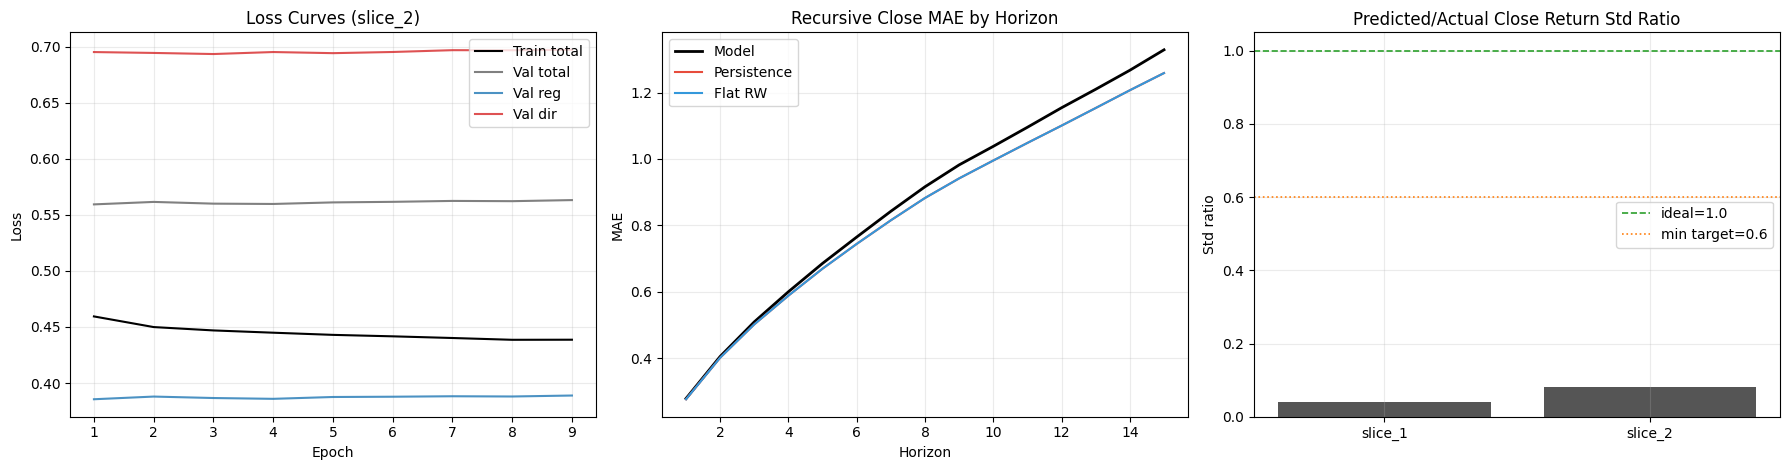

In [10]:
# Acceptance checks + diagnostics
latest = fold_results[-1]

mean_model_mae = float(summary_df['model_close_mae'].mean())
mean_persist_mae = float(summary_df['persist_close_mae'].mean())
mean_dir = float(summary_df['model_directional_acc_eps'].mean())
mean_bias = float(summary_df['model_bias'].mean())
mean_step15_model = float(summary_df['step15_model_mae'].mean())
mean_step15_persist = float(summary_df['step15_persist_mae'].mean())
mean_std_ratio = float(summary_df['pred_actual_std_ratio'].mean())

pred_close_path = latest['pred_future_df']['Close'].to_numpy()
is_monotonic = bool(np.all(np.diff(pred_close_path) >= 0) or np.all(np.diff(pred_close_path) <= 0))

acceptance = {
    'criterion_1_model_mae_20pct_better_than_persistence': mean_model_mae <= 0.8 * mean_persist_mae,
    'criterion_2_directional_accuracy_eps_at_least_0_52': mean_dir >= 0.52,
    'criterion_3_step15_better_than_persistence': mean_step15_model < mean_step15_persist,
    'criterion_4_abs_bias_within_25pct_of_mae': abs(mean_bias) <= 0.25 * mean_model_mae,
    'criterion_5_non_monotonic_latest_prediction_path': not is_monotonic,
    'criterion_6_prediction_variance_not_collapsed': mean_std_ratio >= 0.60,
}

print('Acceptance checks:')
for k, v in acceptance.items():
    print(f'  {k}: {v}')

fig, axes = plt.subplots(1, 3, figsize=(18, 4.8), facecolor='white')

hist = latest['history_df']
axes[0].plot(hist['epoch'], hist['train_total'], label='Train total', color='black')
axes[0].plot(hist['epoch'], hist['val_total'], label='Val total', color='gray')
axes[0].plot(hist['epoch'], hist['val_reg'], label='Val reg', color='#1f77b4', alpha=0.8)
axes[0].plot(hist['epoch'], hist['val_dir'], label='Val dir', color='#d62728', alpha=0.8)
axes[0].set_title(f"Loss Curves ({latest['fold']})")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(alpha=0.25)
axes[0].legend()

axes[1].plot(horizon_stats['horizon'], horizon_stats['model_close_mae'], label='Model', color='black', linewidth=2.0)
axes[1].plot(horizon_stats['horizon'], horizon_stats['persistence_close_mae'], label='Persistence', color='#E74C3C')
axes[1].plot(horizon_stats['horizon'], horizon_stats['flat_close_mae'], label='Flat RW', color='#3498DB')
axes[1].set_title('Recursive Close MAE by Horizon')
axes[1].set_xlabel('Horizon')
axes[1].set_ylabel('MAE')
axes[1].grid(alpha=0.25)
axes[1].legend()

axes[2].bar(summary_df['fold'], summary_df['pred_actual_std_ratio'], color='#555555')
axes[2].axhline(1.0, color='#2ca02c', linestyle='--', linewidth=1.2, label='ideal=1.0')
axes[2].axhline(0.6, color='#ff7f0e', linestyle=':', linewidth=1.2, label='min target=0.6')
axes[2].set_title('Predicted/Actual Close Return Std Ratio')
axes[2].set_ylabel('Std ratio')
axes[2].grid(alpha=0.25)
axes[2].legend()

plt.tight_layout()
plt.show()


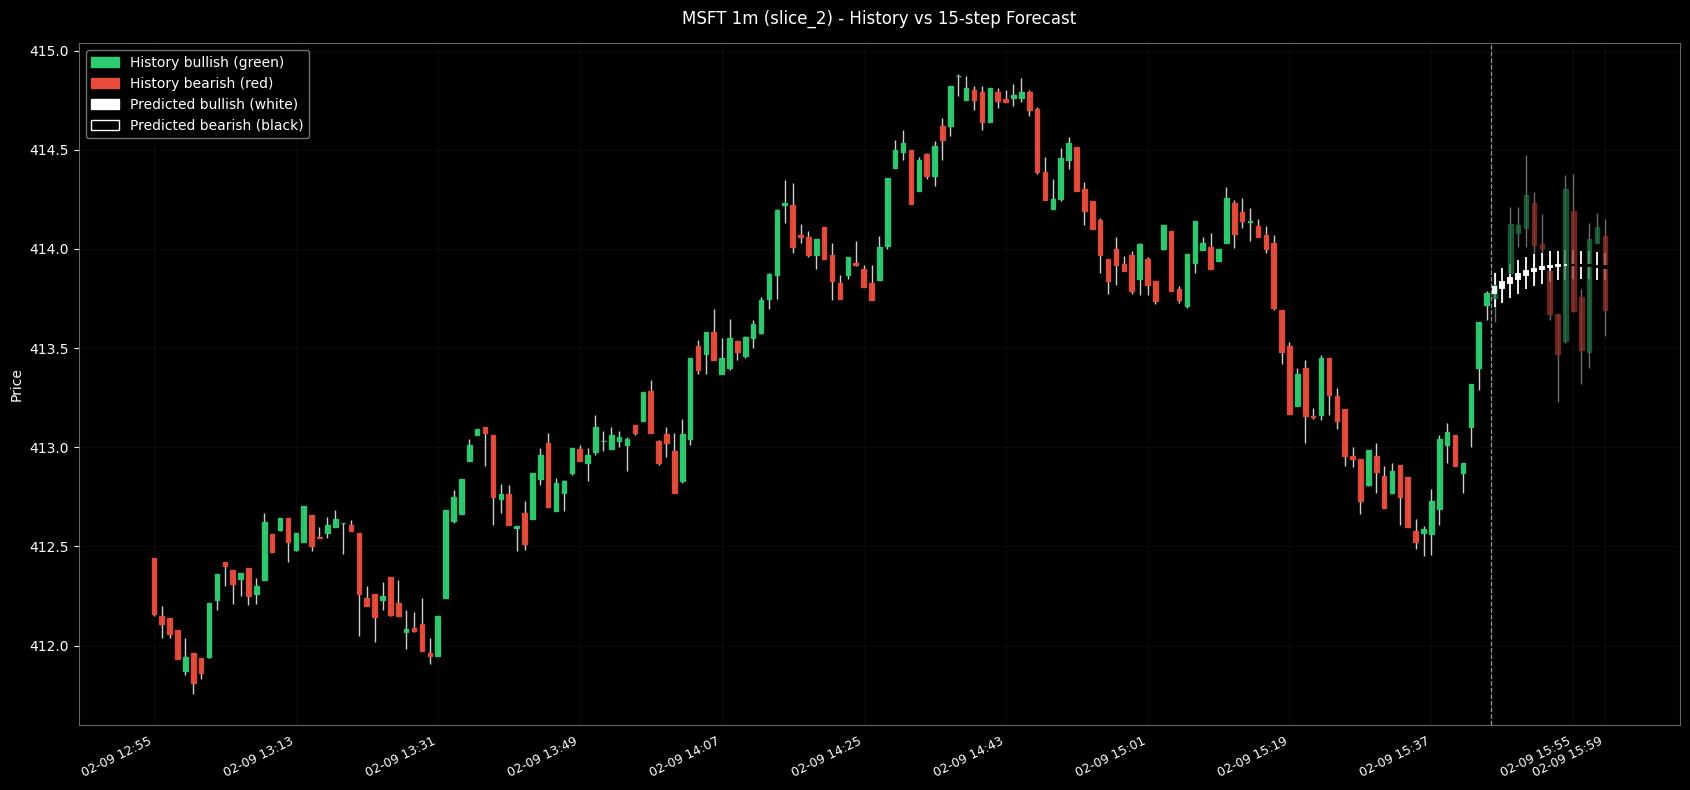

In [11]:
# Final candlestick chart (history green/red, predicted white/black)
def draw_candles(
    ax,
    ohlc: pd.DataFrame,
    start_x: int,
    up_edge: str,
    up_face: str,
    down_edge: str,
    down_face: str,
    wick_color: str,
    width: float = 0.62,
    lw: float = 1.0,
    alpha: float = 1.0,
):
    vals = ohlc[OHLC_COLS].to_numpy()
    for i, (o, h, l, c) in enumerate(vals):
        x = start_x + i
        bull = c >= o

        ax.vlines(x, l, h, color=wick_color, linewidth=lw, alpha=alpha, zorder=2)

        lower = min(o, c)
        height = abs(c - o)
        if height < 1e-8:
            height = 1e-6

        rect = Rectangle(
            (x - width / 2, lower),
            width,
            height,
            facecolor=up_face if bull else down_face,
            edgecolor=up_edge if bull else down_edge,
            linewidth=lw,
            alpha=alpha,
            zorder=3,
        )
        ax.add_patch(rect)


context_df = latest['context_df']
actual_future_df = latest['actual_future_df']
pred_future_df = latest['pred_future_df']

fig, ax = plt.subplots(figsize=(17, 8), facecolor='black')
ax.set_facecolor('black')

draw_candles(ax, context_df, 0, '#2ECC71', '#2ECC71', '#E74C3C', '#E74C3C', '#DADADA', width=0.58, lw=1.0, alpha=0.95)
draw_candles(ax, actual_future_df, len(context_df), '#1D6F42', '#1D6F42', '#8E2F25', '#8E2F25', '#9A9A9A', width=0.58, lw=1.0, alpha=0.70)
draw_candles(ax, pred_future_df, len(context_df), '#FFFFFF', '#FFFFFF', '#000000', '#000000', '#F5F5F5', width=0.50, lw=1.35, alpha=1.0)

ax.axvline(len(context_df) - 0.5, color='white', linestyle='--', linewidth=0.9, alpha=0.6)

idx = context_df.index.append(actual_future_df.index)
n = len(idx)
step = max(1, n // 10)
ticks = list(range(0, n, step))
if ticks[-1] != n - 1:
    ticks.append(n - 1)

labels = [idx[i].strftime('%m-%d %H:%M') for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=26, ha='right', color='white', fontsize=9)

ax.tick_params(axis='y', colors='white')
for sp in ax.spines.values():
    sp.set_color('#666666')

ax.grid(color='#252525', linewidth=0.6, alpha=0.35)
ax.set_title(f'MSFT 1m ({latest["fold"]}) - History vs 15-step Forecast', color='white', pad=14)
ax.set_ylabel('Price', color='white')

legend_elements = [
    Patch(facecolor='#2ECC71', edgecolor='#2ECC71', label='History bullish (green)'),
    Patch(facecolor='#E74C3C', edgecolor='#E74C3C', label='History bearish (red)'),
    Patch(facecolor='#FFFFFF', edgecolor='#FFFFFF', label='Predicted bullish (white)'),
    Patch(facecolor='#000000', edgecolor='#FFFFFF', label='Predicted bearish (black)'),
]
leg = ax.legend(handles=legend_elements, facecolor='black', edgecolor='#707070', framealpha=1.0, loc='upper left')
for t in leg.get_texts():
    t.set_color('white')

plt.tight_layout()
plt.show()


## Notes

- If `pred_actual_std_ratio` stays very low (<0.6), predictions are still volatility-collapsed.
- The model now learns a richer latent state via volume/order-flow proxies, but with IEX feed quality constraints this remains challenging.
- If results are still weak, next step is richer market microstructure data (quotes/trades) and/or horizon-specific objective tuning.
